# COVID 19 classification

In [1]:
import os
import torch
from os import path
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
#Migracio
torch.cuda.is_available()

/home/elloret/env/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


False

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [4]:
from fastai.vision.all import *
from fastai.data.transforms import *
from fastai.data.core import *
from fastai.vision import data
from fastai.metrics import error_rate
import fastai; fastai.__version__
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

/home/elloret/env/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [6]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_level_1 = 256
size_level_2 = 512

## data

In [7]:
path ='/home/robert/data/covid/'; path
os.path.exists("/home/robert/data/covid/train/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg".strip())

True

### Load Normal and pneumonia from dataset (not covids!) 

In [8]:
dfTrain = pd.read_csv(path+'train_split_v2_n.csv', header=None)
dfTrain['valid'] = 0
dfTrain[0] = 'train/' + dfTrain[0].astype(str)
eliminar=[]
for index, row in dfTrain.iterrows():
    if(not os.path.exists(str(path+dfTrain.iloc[index,0]).strip())):
        eliminar.append(index)
        
for i in reversed(eliminar):
    dfTrain.drop(i,inplace=True)
    
dfTrain.head()

,0,1,valid
1,train/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg,pneumonia,0
2,train/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg,pneumonia,0
3,train/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg,pneumonia,0
4,train/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg,pneumonia,0
5,train/SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg,pneumonia,0


### Load COVID for training from covid_vicorob

In [9]:
dfTrainCovid = pd.read_csv(path+'covid_vicorob/covid_vicorob.csv', header=None)
dfTrainCovid['valid'] = 0
dfTrainCovid[0] = 'covid_vicorob/' + dfTrainCovid[0].astype(str)
eliminar=[]
for index, row in dfTrainCovid.iterrows():
    if(not os.path.exists(str(path+dfTrainCovid.iloc[index,0]).strip())):
        eliminar.append(index)
        
for i in reversed(eliminar):
    dfTrainCovid.drop(i,inplace=True)
dfTrainCovid.head()
print(len (dfTrainCovid))
#augment de training covid data 2^3
for i in range(3):
    dfTrainCovid = dfTrainCovid.append(dfTrainCovid)
print(len (dfTrainCovid))

dfTrain = dfTrain.append(dfTrainCovid)

122
976


### Validation data from Seram & Normals

In [10]:
dfTest = pd.read_csv(path+'test_split_v2_n.csv',header=None)
dfTest['valid'] = 1
dfTest[0] = 'test/' + dfTest[0].astype(str)
eliminar=[]
for index, row in dfTest.iterrows():
    if(not os.path.exists(str(path+dfTest.iloc[index,0]).strip())):
        eliminar.append(index)
        
for i in reversed(eliminar):
    dfTest.drop(i,inplace=True)
dfTest.head()

,0,1,valid
0,test/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg,pneumonia,1
1,test/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg,pneumonia,1
2,test/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg,pneumonia,1
3,test/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day2.jpg,pneumonia,1
4,test/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg,pneumonia,1


In [11]:
dfTestCovid = pd.read_csv(path+'seram/covid_seram.csv',header=None)
dfTestCovid['valid'] = 1
dfTestCovid[0] = 'seram/' + dfTestCovid[0].astype(str)
eliminar=[]
for index, row in dfTestCovid.iterrows():
    if(not os.path.exists(str(path+dfTestCovid.iloc[index,0]).strip())):
        eliminar.append(index)
        
for i in reversed(eliminar):
    dfTestCovid.drop(i,inplace=True)
dfTestCovid.head()
dfTest= dfTest.append(dfTestCovid)

In [12]:
df = dfTrain.append(dfTest)
df.head()

,0,1,valid
1,train/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg,pneumonia,0
2,train/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg,pneumonia,0
3,train/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg,pneumonia,0
4,train/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg,pneumonia,0
5,train/SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg,pneumonia,0


In [13]:
dblock = DataBlock()
dsets = dblock.datasets(df)
x,y = dsets.train[0]
x,y

(0        train/d0121f55-3bc9-4228-9f53-0d58cee04651.png
 1                                                normal
 valid                                                 0
 Name: 6501, dtype: object,
 0        train/d0121f55-3bc9-4228-9f53-0d58cee04651.png
 1                                                normal
 valid                                                 0
 Name: 6501, dtype: object)

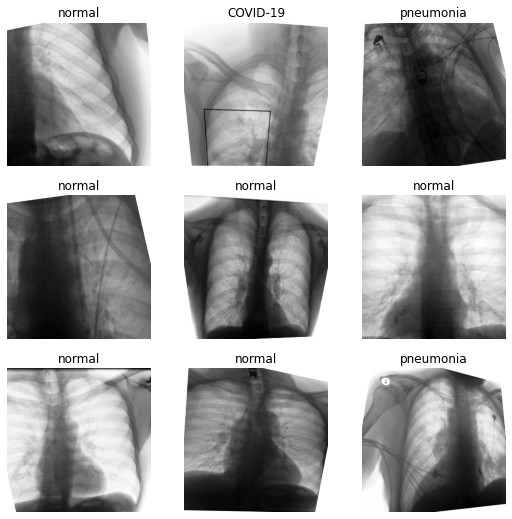

In [14]:
np.random.seed(42)

# src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
#        .split_by_rand_pct(0.2)
#        .label_from_df(label_delim=' '))
def splitter(df):
    train = df.index[df['valid']==0].tolist()
    valid = df.index[df['valid']==1].tolist()
    return train,valid

def get_image(r): return path+r[0]
def get_label(r): return r[1]
tfms = aug_transforms(pad_mode='zeros', max_rotate=8)
dblock= DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 splitter=splitter,
                 get_x=get_image,
                 get_y=get_label,
                 item_tfms = RandomResizedCrop(300),
                 batch_tfms =tfms)
dsets = dblock.dataloaders(df,bs=bs)
dsets.show_batch()

In [15]:
# original tfms = get_tranasforms(do_flip=False) 
# allowing horizontal flips only. 
#tfms = aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
#tfms = get_transforms(flip_vert=False)

In [16]:
#data = #ImageDataBunch.from_df(path=Path('data'), df=df, ds_tfms=get_transforms(), size=224, bs=32)

#data = (dsets.transform(tfms, size=256)
#        .databunch().normalize(imagenet_stats))
#data.batch_size=bs
# lesson 1 data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH)
dsets.sample()

<generator object DataLoader.sample.<locals>.<genexpr> at 0x7f96bc7171a8>

In [17]:
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH)

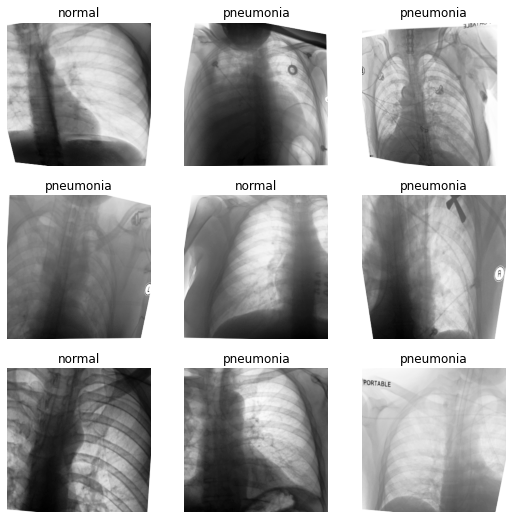

In [18]:
dsets.show_batch()

In [21]:
dsets.train_ds

(#17965) [(PILImageBW mode=L size=1800x1546, TensorCategory(2)),(PILImageBW mode=L size=1772x1800, TensorCategory(2)),(PILImageBW mode=L size=1708x1710, TensorCategory(2)),(PILImageBW mode=L size=1800x1508, TensorCategory(2)),(PILImageBW mode=L size=1800x1522, TensorCategory(2)),(PILImageBW mode=L size=1750x1800, TensorCategory(2)),(PILImageBW mode=L size=1800x1779, TensorCategory(2)),(PILImageBW mode=L size=1787x1800, TensorCategory(2)),(PILImageBW mode=L size=1294x1022, TensorCategory(2)),(PILImageBW mode=L size=1534x1970, TensorCategory(2))...]

In [22]:
dsets.valid_ds

(#2006) [(PILImageBW mode=L size=1800x1546, TensorCategory(2)),(PILImageBW mode=L size=1800x1546, TensorCategory(2)),(PILImageBW mode=L size=1772x1800, TensorCategory(2)),(PILImageBW mode=L size=1708x1710, TensorCategory(2)),(PILImageBW mode=L size=1800x1508, TensorCategory(2)),(PILImageBW mode=L size=1800x1522, TensorCategory(2)),(PILImageBW mode=L size=1750x1800, TensorCategory(2)),(PILImageBW mode=L size=1800x1779, TensorCategory(2)),(PILImageBW mode=L size=1787x1800, TensorCategory(2)),(PILImageBW mode=L size=1294x1022, TensorCategory(2))...]

### Convert to grayscale

In [20]:
for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(data, itemList)
    if itemList: itemList.x.convert_mode = "L"

## learner

In [21]:
'''class fbeta_binary(Callback):
    "Computes the f_beta between preds and targets for binary text classification"

    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      
        self.beta2=beta2**2
        self.eps = eps
        self.sigmoid = sigmoid
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output
        y_pred = y_pred.softmax(dim = 1)        
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)
        res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
        #self.metric = res.mean()
        self.metric = res     
'''

'class fbeta_binary(Callback):\n    "Computes the f_beta between preds and targets for binary text classification"\n\n    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      \n        self.beta2=beta2**2\n        self.eps = eps\n        self.sigmoid = sigmoid\n    \n    def on_epoch_begin(self, **kwargs):\n        self.TP = 0\n        self.total_y_pred = 0   \n        self.total_y_true = 0\n    \n    def on_batch_end(self, last_output, last_target, **kwargs):\n        y_pred = last_output\n        y_pred = y_pred.softmax(dim = 1)        \n        y_pred = y_pred.argmax(dim=1)\n        y_true = last_target.float()\n        \n        self.TP += ((y_pred==1) * (y_true==1)).float().sum()\n        self.total_y_pred += (y_pred==1).float().sum()\n        self.total_y_true += (y_true==1).float().sum()\n    \n    def on_epoch_end(self, **kwargs):\n        prec = self.TP/(self.total_y_pred+self.eps)\n        rec = self.TP/(self.total_y_true+self.eps)\n        res = (prec*rec)/(prec*self

In [30]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

arch = resnet50
#arch = models.densenet161
#learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), AUROC(), error_rate])
learn = cnn_learner(dsets, resnet18, metrics=[accuracy, Precision(average='micro'), error_rate])
torch.cuda.set_device(0)
#learn.fine_tune(1, base_lr=0.01)

RuntimeError: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=4.786300905834651e-06)

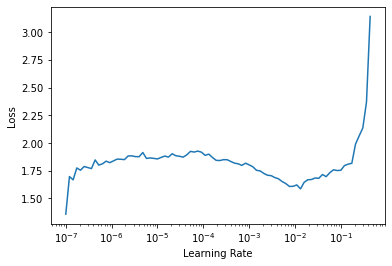

In [73]:
learn.lr_find()

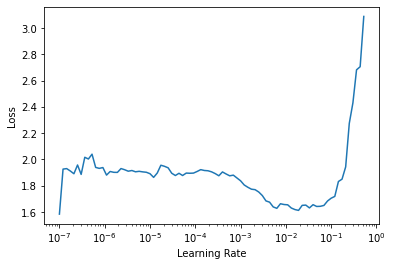

In [66]:
learn.recorder.plot_lr_find()

In [24]:
lr = 0.0013182567432522773

In [25]:
learn.fine_tune(10, base_lr=lr)

epoch,train_loss,valid_loss,accuracy,precision_score,error_rate,time
0,0.627927,0.488777,0.811067,0.811067,0.188933,18:24


epoch,train_loss,valid_loss,accuracy,precision_score,error_rate,time
0,0.423811,0.322211,0.876869,0.876869,0.123131,27:32
1,0.353066,0.216451,0.910768,0.910768,0.089232,27:28
2,0.327327,0.092303,0.962612,0.962612,0.037388,27:29
3,0.316446,0.139868,0.955135,0.955135,0.044865,27:26
4,0.272433,0.095065,0.964108,0.964108,0.035892,27:20
5,0.287001,0.082982,0.976570,0.976570,0.023430,27:29
6,0.259429,0.073804,0.975573,0.975573,0.024427,27:22
7,0.208471,0.068188,0.976072,0.976072,0.023928,27:28
8,0.209363,0.045267,0.988534,0.988534,0.011466,27:29
9,0.217848,0.054934,0.985045,0.985045,0.014955,27:40


In [27]:
learn.save('stage-1-256-dn18')

Path('models/stage-1-256-dn18.pth')

In [33]:
learn.fine_tune(1, base_lr=lr)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/elloret/env/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/elloret/env/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/home/elloret/env/lib/python3.6/site-packages/fastai/data/load.py", line 110, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/elloret/env/lib/python3.6/site-packages/fastcore/basics.py", line 198, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/home/elloret/env/lib/python3.6/site-packages/fastai/data/load.py", line 125, in do_item
    try: return self.after_item(self.create_item(s))
  File "/home/elloret/env/lib/python3.6/site-packages/fastai/data/load.py", line 131, in create_item
    def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]
  File "/home/elloret/env/lib/python3.6/site-packages/fastai/data/core.py", line 314, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/home/elloret/env/lib/python3.6/site-packages/fastai/data/core.py", line 314, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/home/elloret/env/lib/python3.6/site-packages/fastai/data/core.py", line 280, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/home/elloret/env/lib/python3.6/site-packages/fastai/data/core.py", line 242, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/home/elloret/env/lib/python3.6/site-packages/fastcore/transform.py", line 198, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/home/elloret/env/lib/python3.6/site-packages/fastcore/transform.py", line 150, in compose_tfms
    x = f(x, **kwargs)
  File "/home/elloret/env/lib/python3.6/site-packages/fastcore/transform.py", line 73, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/home/elloret/env/lib/python3.6/site-packages/fastcore/transform.py", line 83, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/home/elloret/env/lib/python3.6/site-packages/fastcore/transform.py", line 89, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/home/elloret/env/lib/python3.6/site-packages/fastcore/dispatch.py", line 129, in __call__
    return f(*args, **kwargs)
  File "<ipython-input-14-928e2c0ec05c>", line 11, in get_image
    def get_image(r): return path+r[0]
TypeError: unsupported operand type(s) for +: 'module' and 'str'


In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [52]:
dsets.vocab

['COVID-19']

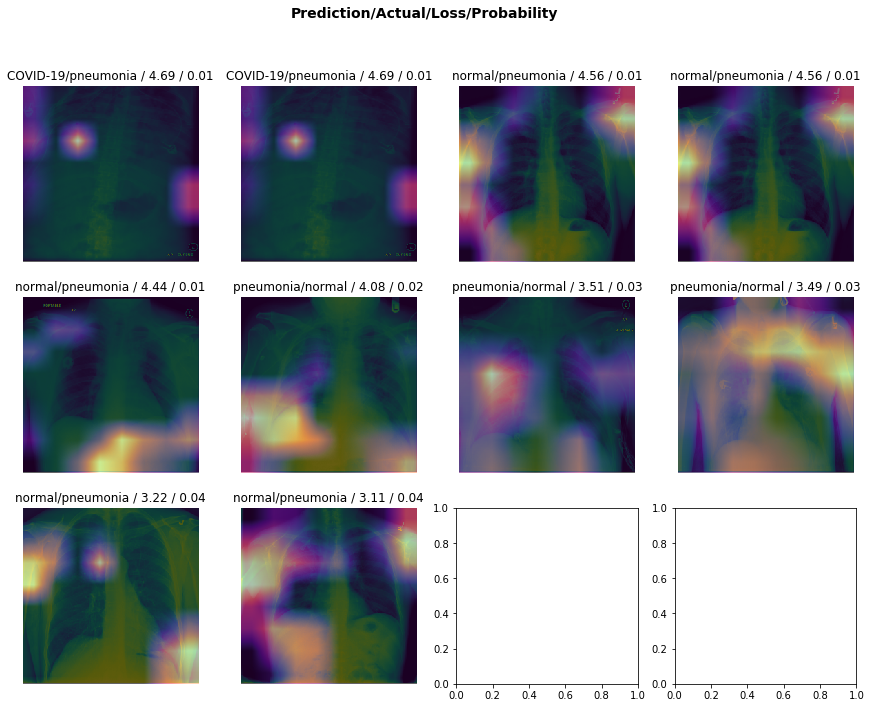

In [30]:
interp.plot_top_losses(10, figsize=(15,11), heatmap= True)

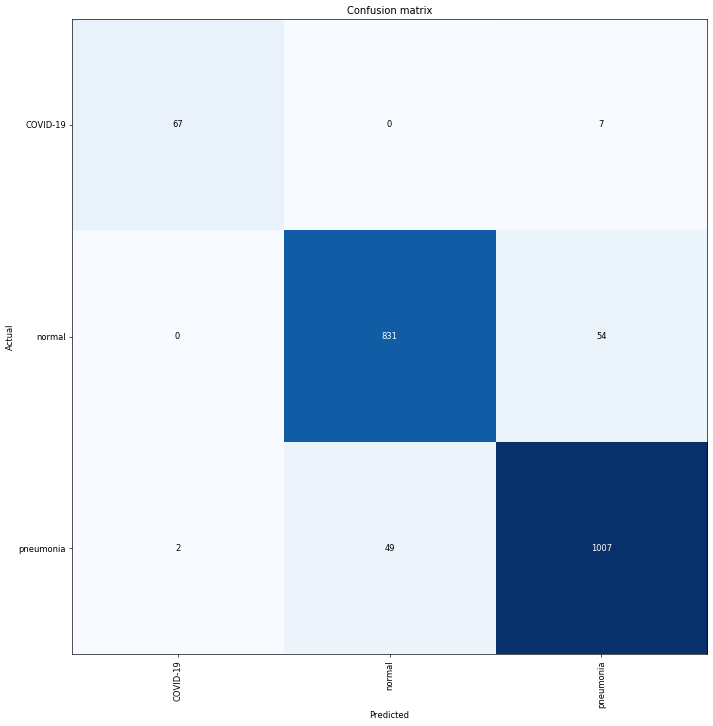

In [31]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
interp.most_confused(min_val=1)

[('normal', 'pneumonia', 54),
 ('pneumonia', 'normal', 49),
 ('COVID-19', 'pneumonia', 7),
 ('pneumonia', 'COVID-19', 2)]

In [33]:
learn.unfreeze()

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Failed to compute the gradients, there might not be enough points.


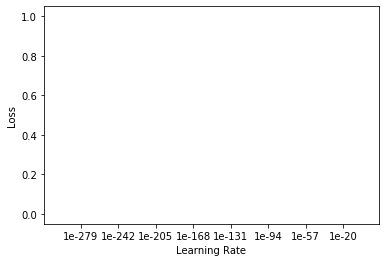

In [35]:
learn.recorder.plot(suggestion=True)

In [36]:
learn.fit_one_cycle(10,slice(1e-5, lr/2))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.192199,0.155287,0.938523,0.930370,0.061477,01:55
1,0.202528,0.157769,0.942985,0.910938,0.057015,02:01
2,0.192358,0.121091,0.954884,0.959745,0.045117,01:58
3,0.161236,0.138541,0.948438,0.963893,0.051562,01:58
4,0.146100,0.124474,0.955379,0.949358,0.044621,01:57
5,0.116072,0.105324,0.962816,0.973854,0.037184,01:57
6,0.100573,0.119455,0.957362,0.969821,0.042638,01:57
7,0.063071,0.107126,0.961329,0.972838,0.038671,01:57
8,0.054831,0.105740,0.964303,0.974910,0.035697,01:58
9,0.048430,0.109347,0.967278,0.976982,0.032722,02:00


In [37]:
learn.save('stage-2-256-rn50')


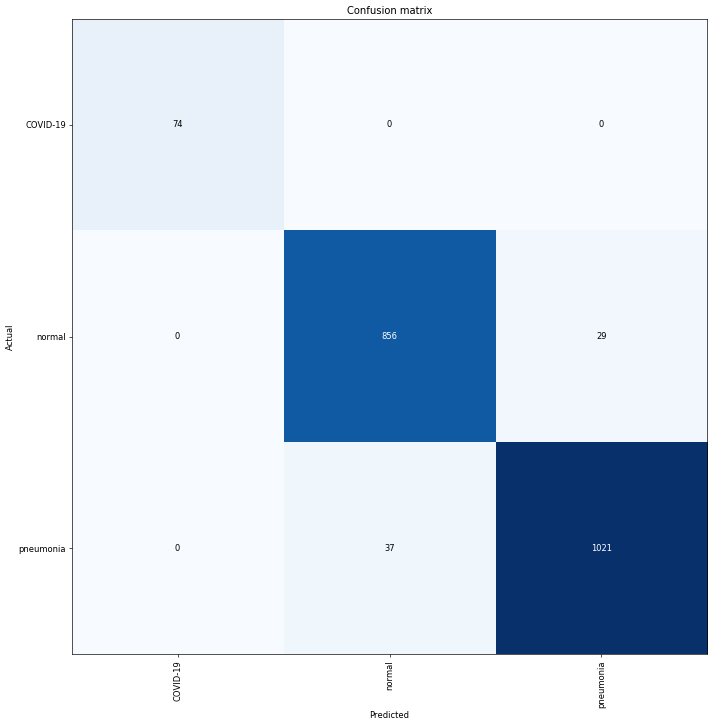

In [38]:

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### increasing image size

In [39]:
data = (src.transform(tfms, size=512)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.batch_size = bs
data.train_ds[0][0].shape

torch.Size([1, 512, 512])

In [40]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


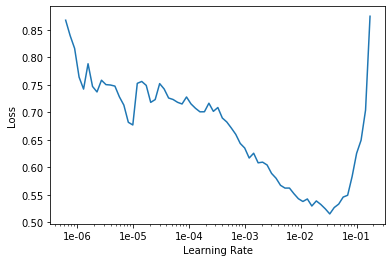

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr=1e-3/2

In [43]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.249905,0.169877,0.931582,0.930226,0.068418,04:19
1,0.157937,0.130668,0.954884,0.963907,0.045117,04:17
2,0.156713,0.117015,0.955379,0.968465,0.044621,04:17
3,0.145990,0.111705,0.962816,0.973573,0.037184,04:17
4,0.120201,0.107243,0.961329,0.972559,0.038671,04:17
5,0.106633,0.107833,0.959346,0.971367,0.040654,04:17
6,0.099061,0.104390,0.959346,0.971335,0.040654,04:17
7,0.102640,0.104148,0.956371,0.969346,0.043629,04:17
8,0.087390,0.104285,0.958850,0.971151,0.041150,04:17
9,0.087162,0.104601,0.957858,0.970296,0.042142,04:17


In [44]:
learn.save('stage-1-512-rn50')

In [45]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


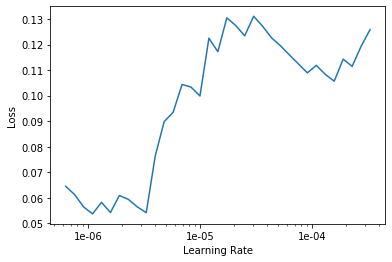

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,precision,error_rate,time
0,0.086217,0.111783,0.960337,0.972979,0.039663,05:58
1,0.075963,0.104062,0.962816,0.974387,0.037184,05:59
2,0.113208,0.100528,0.965295,0.971322,0.034705,05:58
3,0.083415,0.115162,0.960833,0.973365,0.039167,05:57
4,0.075608,0.107554,0.959841,0.971866,0.040159,05:59
5,0.079532,0.106382,0.960337,0.971926,0.039663,06:00
6,0.037263,0.120328,0.962816,0.974142,0.037184,06:02
7,0.027652,0.119046,0.959346,0.971543,0.040654,06:00
8,0.032322,0.125481,0.962320,0.973305,0.037680,05:59
9,0.017066,0.125337,0.960337,0.972037,0.039663,06:02


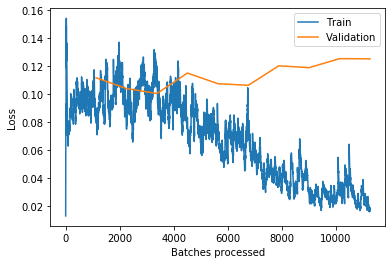

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save('stage-2-512-rn50')


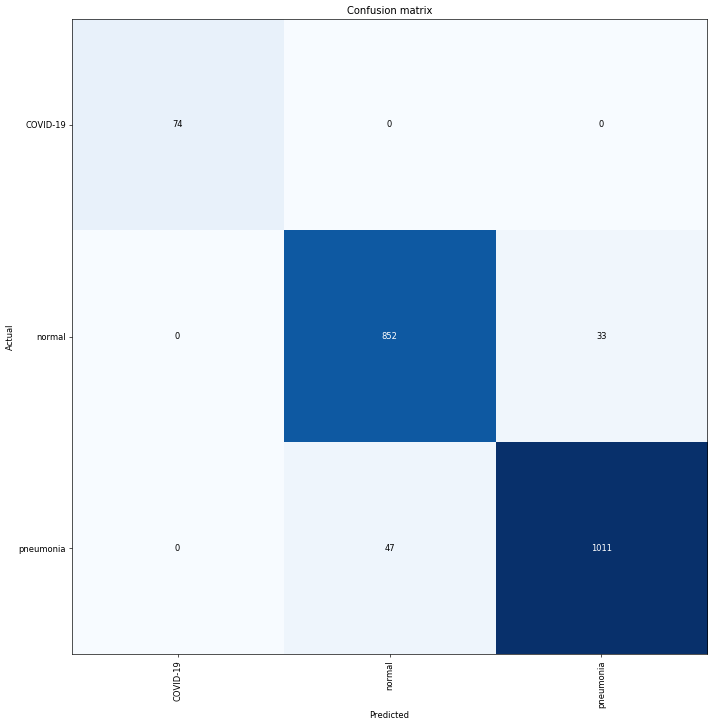

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

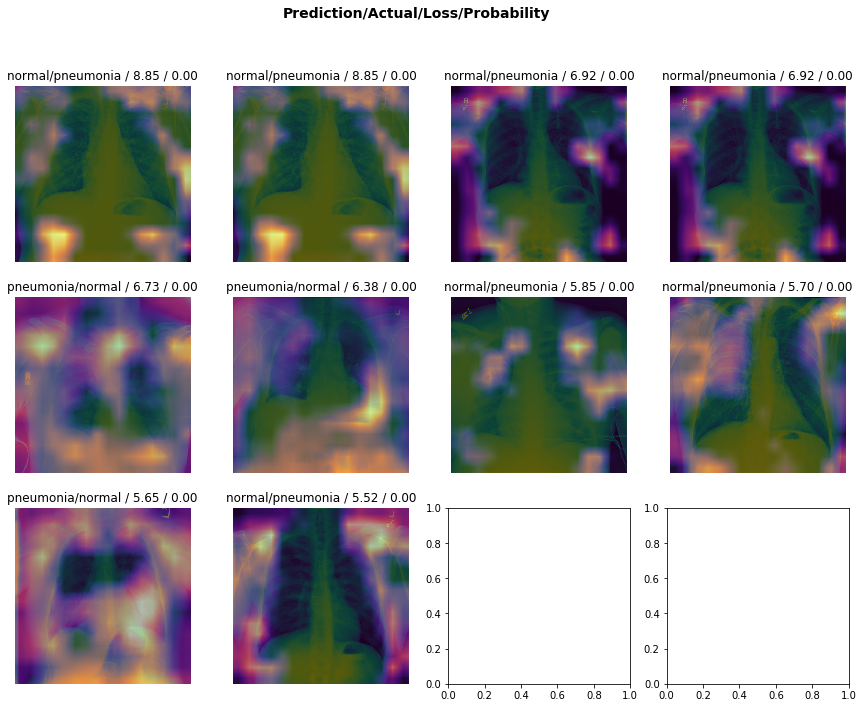

In [51]:
interp.plot_top_losses(10, figsize=(15,11), largest=True, heatmap= True)

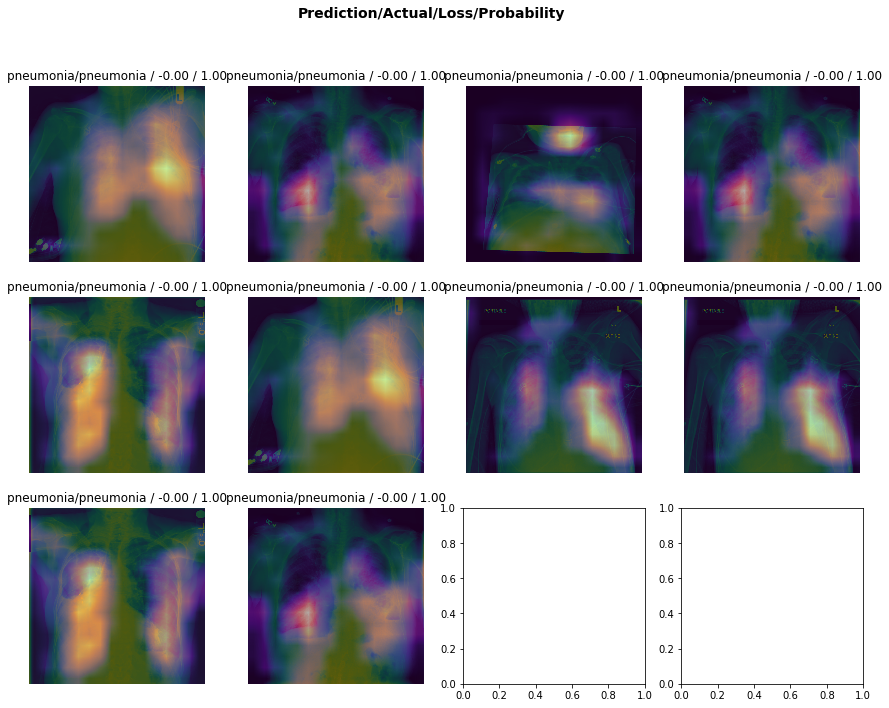

In [52]:
interp.plot_top_losses(10, figsize=(15,11), largest=False, heatmap= True)

In [53]:
learn.export('trainedAllData_resnet_512_export.pkl')

### Test on new data

In [13]:
learn = load_learner(path,'trainedAllData_resnet_512_export.pkl')


#preds,y = learn.get_preds()



In [15]:
#dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
#dfTest[0] = 'covid_local/' + dfTest[0].astype(str)
#dfTest.head()

#CSMS
dfTest = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
dfTest[0] = 'CSMS/' + dfTest[0].astype(str)
dfTest.head()


#dfTest2 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
#dfTest2[0] = 'padchest/' + dfTest[0].astype(str)
#dfTest2.head()

#dfTest = dfTest.append(dfTest2)
#dfTest.head()




#preds,y = learn.get_preds(ds_type=DatasetType.Train)

#data_test = (TabularList.from_df(test, path=nbPath, cat_names=cat_var, cont_names=cont_var,
                          # procs=procs, processor=data.processor)
#       .split_none()
#       .label_from_df(dep_var, classes=classes)
#       .databunch())
#learn.data.valid_dl = data_test.train_dl

#cls = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

,0,1
0,CSMS/001_CSMS.jpg,COVID-19
1,CSMS/002_CSMS.jpg,COVID-19
2,CSMS/003_CSMS.jpg,COVID-19
3,CSMS/004_CSMS.jpg,normal
4,CSMS/005_CSMS.jpg,normal


In [20]:
src = (ImageList.from_df(df=dfTest,path=path,convert_mode='L')
    .split_none()
    .label_from_df())

test = (src.transform(tfms, size=512)
        .databunch(no_check=False,bs=1).normalize(imagenet_stats))
test.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f54587e8b38>, device=device(type='cuda', index=0), tfms=[functools.partial(<function _normalize_batch at 0x7f54591b6598>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f54615ea268>)

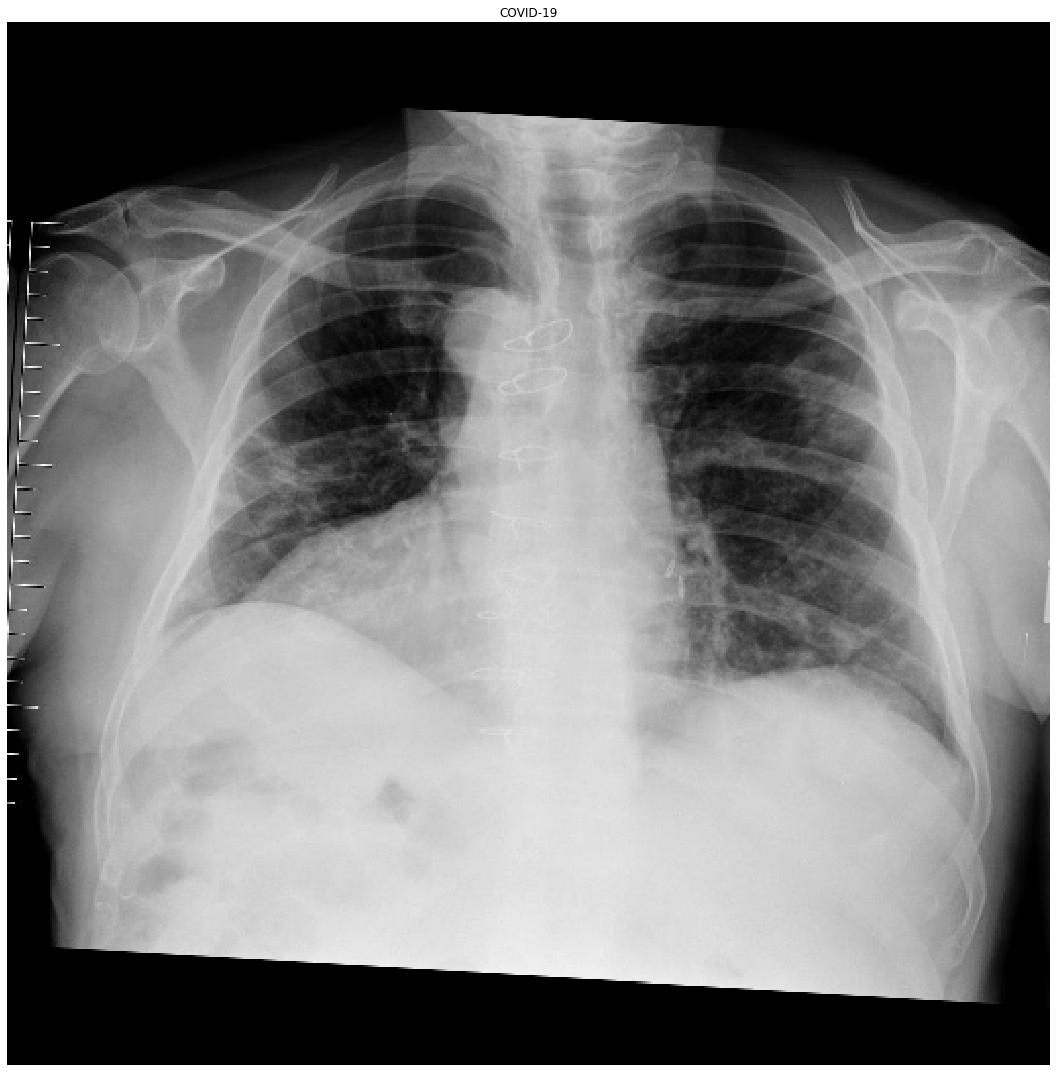

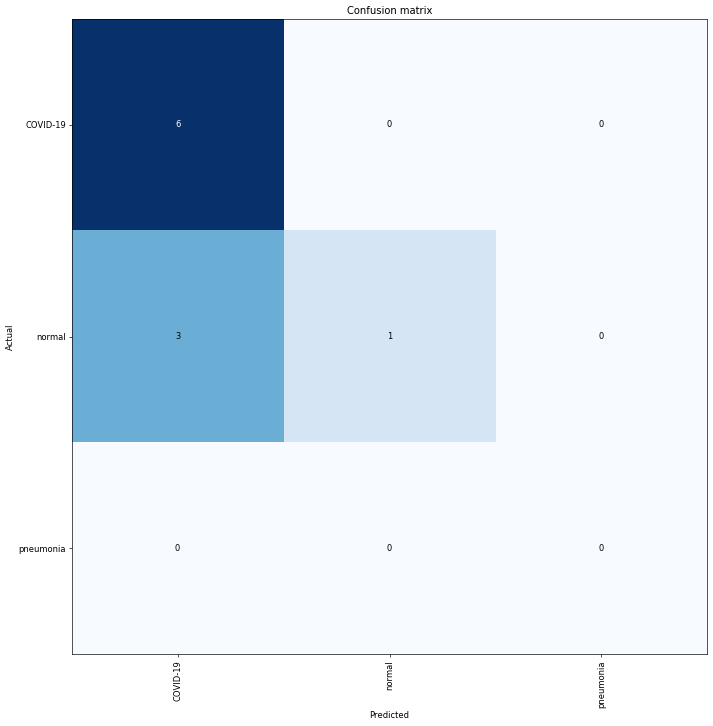

In [21]:
test.valid_dl = test.train_dl

test.show_batch(rows=10,figsize=(15,15))

for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(test, itemList)
    if itemList: itemList.x.convert_mode = "L"


learn.data.valid_dl = test.train_dl
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [60]:
log_preds, y = learn.get_preds()

predIdxs = np.argmax(log_preds.numpy(), axis=1)
print(exp(log_preds))



tensor([[1.0020, 2.6998, 1.0048],
        [2.7176, 1.0000, 1.0003],
        [1.0724, 2.2733, 1.1150],
        [2.3426, 1.0007, 1.1596],
        [1.0000, 1.0005, 2.7170],
        [2.7110, 1.0001, 1.0026],
        [2.7163, 1.0000, 1.0007],
        [2.7183, 1.0000, 1.0000],
        [1.0011, 2.7126, 1.0010],
        [2.6699, 1.0066, 1.0114],
        [2.6169, 1.0036, 1.0350],
        [2.5808, 1.0048, 1.0483],
        [2.7173, 1.0001, 1.0003],
        [2.6821, 1.0096, 1.0038],
        [2.7057, 1.0005, 1.0041],
        [1.0000, 1.0002, 2.7177],
        [2.4456, 1.0000, 1.1115],
        [2.7182, 1.0000, 1.0000],
        [2.6991, 1.0027, 1.0044],
        [1.0180, 2.6685, 1.0006],
        [2.7166, 1.0003, 1.0003],
        [2.7152, 1.0002, 1.0009],
        [2.5212, 1.0782, 1.0000],
        [2.7142, 1.0000, 1.0015],
        [2.7123, 1.0000, 1.0022],
        [2.6852, 1.0000, 1.0123],
        [2.0844, 1.3037, 1.0003],
        [2.5152, 1.0000, 1.0807],
        [2.3840, 1.0011, 1.1389],
        [2.718

In [58]:
len(data.valid_ds)
predIdxs
log_preds
predIdxs

array([2, 2, 2, 2, ..., 2, 2, 2, 2])

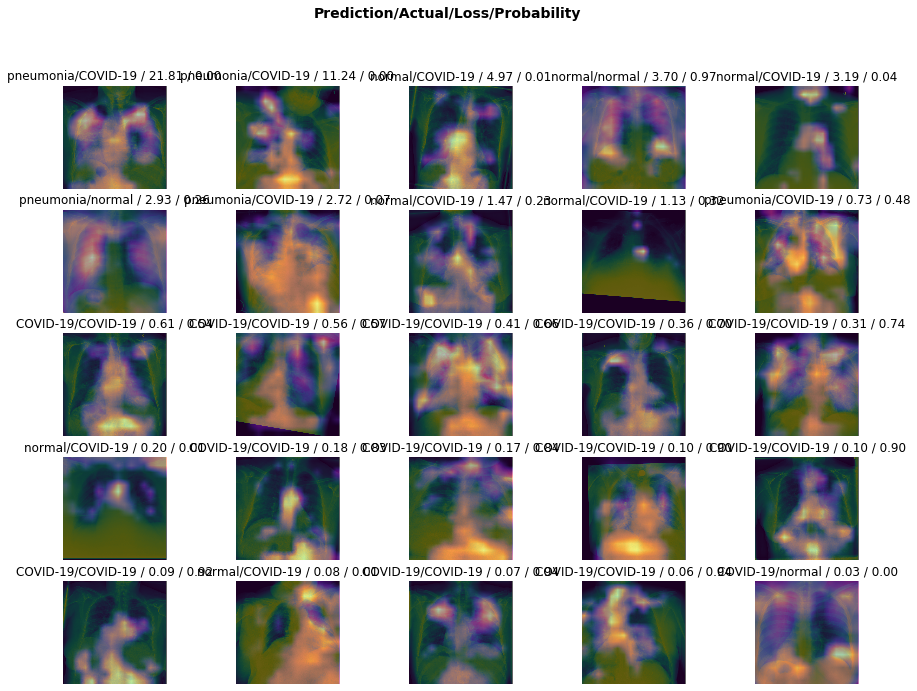

In [80]:
interp.plot_top_losses(25, figsize=(15,11), largest=True, heatmap= True)